In [19]:
import datetime
import gc
import os
import sys
from glob import glob
import matplotlib.pyplot as plt
from pathlib import Path

from glob import glob
import numpy as np
import pandas as pd
import polars as pl
import torch
import yaml
from tqdm import tqdm

TRAIN_OR_TEST = "train"

paths = glob(
    f"../input/child-mind-institute-problematic-internet-use/series_{TRAIN_OR_TEST}.parquet/id=*/part-0.parquet"
)
print(len(paths))

996


In [20]:
if True:
    sys.path.append("../input/cmi-2023-src")
    from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD
    from torch_models.dataset import ZzzPatchDataset
    from torch_models.models import ZzzConv1dGRUModel, ZzzTransformerGRUModel, ZzzWaveGRUModel

    from utils.feature_contena import Features
    from utils.lightning_utils import MyLightningDataModule, MyLightningModule
    from utils.set_seed import seed_base_torch
    from utils.torch_template import EnsembleModel

In [21]:
def transform(df, night_offset=20):
    return (
        df.with_columns(
            [
                (pl.col("timestamp").dt.year() - 2000).cast(pl.Int8).alias("year"),
                pl.col("timestamp").dt.month().cast(pl.Int8).alias("month"),
                pl.col("timestamp").dt.day().cast(pl.Int8).alias("day"),
                pl.col("timestamp").dt.hour().cast(pl.Int8).alias("hour"),
                pl.col("timestamp").dt.minute().cast(pl.Int8).alias("minute"),
                pl.col("timestamp").dt.second().cast(pl.Int8).alias("second"),
                pl.col("timestamp").dt.weekday().cast(pl.Int8).alias("weekday"),
            ]
        )
        .with_columns( 
            pl.when(pl.col("hour") < night_offset)
            .then(pl.col("timestamp"))
            .otherwise(pl.col("timestamp") + pl.duration(days=1))
            .dt.date()
            .alias("night_group"),
        )
        .with_columns(
            [
                (
                    pl.col("series_id") + pl.lit("_") + pl.col("night_group").cast(pl.Datetime).dt.strftime("%Y%m%d")
                ).alias("group_id"),
            ]
        )
        .with_columns(
            [
                pl.col("timestamp").cum_count().over("group_id").alias("norm_step"),
            ]
        )
        .drop(["night_group"])
    )


def transform_series(df):
    return transform(df).with_columns(
        [
            (pl.col("enmo") == 0).alias("is_enmo_clipped"),
        ]
    )


def transform_events(df):
    return (
        transform(df)
        .with_columns(
            [
                pl.col("night").cast(pl.UInt32).alias("night"),
            ]
        )
        .pivot(["step", "timestamp", "tz_offset"], ["series_id", "group_id", "night"], "event")
    )


def add_feature(
    df,
    day_group_col="group_id",
    term1=(5 * 60) // 5,
    term2=(30 * 60) // 5,
    term3=(60 * 60) // 5,
    min_threshold=0.005,
    max_threshold=0.04,
    center=True,
):
    return (
        df.with_columns(
            [
                pl.col("anglez").diff(1).abs().alias("anglez_diff"),
                pl.col("enmo").diff(1).abs().alias("enmo_diff"),
            ]
        )
        .with_columns(
            [
                pl.col("anglez_diff")
                .rolling_median(term1, center=center)  # 5 min window
                .alias("anglez_diff_median_5min"),
                pl.col("enmo_diff")
                .rolling_median(term1, center=center)  # 5 min window
                .alias("enmo_diff_median_5min"),
            ]
        )
        .with_columns(
            [
                pl.col("anglez_diff_median_5min")
                .quantile(0.1)
                .clip(min_threshold, max_threshold)
                .over(day_group_col)
                .alias("critical_threshold")
            ]
        )
        .with_columns([(pl.col("anglez_diff_median_5min") < pl.col("critical_threshold") * 15).alias("is_static")])
        .with_columns(
            [
                pl.col("is_static").cast(pl.Int32).rolling_sum(term2, center=center).alias("is_static_sum_30min"),
            ]
        )
        .with_columns([(pl.col("is_static_sum_30min") == ((30 * 60) // 5)).alias("tmp")])
        .with_columns(
            [
                pl.col("tmp").shift(term2 // 2).alias("tmp_left"),
                pl.col("tmp").shift(-(term2 // 2)).alias("tmp_right"),
            ]
        )
        .with_columns(
            [
                (pl.col("tmp_left") | pl.col("tmp_right")).alias("is_sleep_block"),
            ]
        )
        .drop(["tmp", "tmp_left", "tmp_right"])
        .with_columns([pl.col("is_sleep_block").not_().alias("is_gap")])
        .with_columns([pl.col("is_gap").cast(pl.Int32).rolling_sum(term3, center=center).alias("gap_length")])
        .with_columns([(pl.col("gap_length") == term3).alias("tmp")])
        .with_columns(
            [
                pl.col("tmp").shift(term3 // 2).alias("tmp_left"),
                pl.col("tmp").shift(-(term3 // 2)).alias("tmp_right"),
            ]
        )
        .with_columns(
            [
                (pl.col("tmp_left") | pl.col("tmp_right")).alias("is_large_gap"),
            ]
        )
        .drop(["tmp", "tmp_left", "tmp_right"])
        .with_columns([pl.col("is_large_gap").not_().alias("is_sleep_episode")])
        #
        # extract longest sleep episode
        #
        .with_columns(
            [
                # extract false->true transition
                (
                    (
                        pl.col("is_sleep_episode")
                        & pl.col("is_sleep_episode").shift(1, fill_value=pl.lit(False)).not_()
                    )
                    .cum_sum()
                    .over("group_id")
                ).alias("sleep_episode_id")
            ]
        )
        .with_columns(
            [pl.col("is_sleep_episode").sum().over(["group_id", "sleep_episode_id"]).alias("sleep_episode_length")]
        )
        .with_columns([pl.col("sleep_episode_length").max().over(["group_id"]).alias("max_sleep_episode_length")])
        .with_columns(
            [
                (
                    pl.col("is_sleep_episode") & (pl.col("sleep_episode_length") == pl.col("max_sleep_episode_length"))
                ).alias("is_longest_sleep_episode")
            ]
        )
    )


use_columns = [
    "series_id",
    "step",
    "is_longest_sleep_episode",
    "is_sleep_block",
    "is_gap",
    "is_large_gap",
    "is_sleep_episode",
    "is_static",
]

for path in tqdm(paths):
    sdf = pl.read_parquet(path)

    # dummy timestamp
    sdf = sdf.with_columns((pl.col("time_of_day") == 0).cast(pl.Int32).cum_sum().alias("day_offset"))
    sdf = sdf.with_columns(
        (
            datetime.datetime(2020, 1, 1)
            + (pl.col("day_offset") * 86400_000_000 + pl.col("time_of_day") / 1000).cast(pl.Duration("us"))
        ).alias("timestamp")
    )

    sdf = sdf.with_columns(pl.lit(path.split("/")[-2]).alias("series_id"))
    sdf = sdf.sort("step")
    sdf = transform_series(sdf)
    sdf = add_feature(sdf)
    sdf = sdf[use_columns].fill_null(False)

    sidf = path.split("/")[-2]
    save_path = f"../working/heuristic_features/{sidf}.parquet"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    sdf.write_parquet(save_path)

100%|██████████| 996/996 [08:25<00:00,  1.97it/s]


In [22]:
MODEL_NAME = "patch_transformer_gru"

PACKAGE_DIR = Path("../input/cmi-2023-src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

CFG["output_dir"] = f"../input/cmi-2023-output/{CFG[MODEL_NAME]['execution']['best_exp_id']}"

seed_base_torch(CFG["env"]["seed"])

DEVICE = "cuda"

files = glob(
    f"../input/child-mind-institute-problematic-internet-use/series_{TRAIN_OR_TEST}.parquet/id=*/part-0.parquet"
)

features = Features()
features.add_num_features(["anglez", "enmo"])
features.add_num_features(["anglez_diff", "enmo_diff"])
features.add_num_features(["same_count"])
features.add_num_features(["large_diff_count"])
features.add_num_features(["same_count_shift_plus", "same_count_shift_minus"])
features.add_num_features(["is_longest_sleep_episode", "is_sleep_block"])

# transformer + gru
model = ZzzTransformerGRUModel(
    max_len=BLOCK_SIZE // CFG[MODEL_NAME]["execution"]["patch_size"],
    input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
    **CFG[MODEL_NAME]["params"],
)
trn_models = [
    MyLightningModule.load_from_checkpoint(
        os.path.join("../input/cmi-2023-output/exp_160", f"logs/best_model_fold{fold}.ckpt"),
        model=model,
        map_location=torch.device(DEVICE),
    ).to(DEVICE)
    for fold in range(5 if len(files) > 100 else 1)
]

models = trn_models
model = EnsembleModel(models).to(DEVICE)
model.eval()

all_oof_dfs = []
for file in tqdm(files):
    # load file
    df = pd.read_parquet(file)
    if len(df) < BLOCK_SIZE:
        continue
    time_of_days = df["time_of_day"].values

    # same_count
    DAY_STEPS = 12 * 60 * 24
    n_days = int(len(df) // DAY_STEPS) + 1
    df["same_count"] = 0
    for day in range(-n_days, n_days + 1):
        if day == 0:
            continue
        df["_anglez_diff"] = df["anglez"].diff(DAY_STEPS * day)
        df["_anglez_diff"] = df["_anglez_diff"].fillna(1)
        df["same_count"] += (df["_anglez_diff"] == 0).astype(int)
    df["same_count"] = (df["same_count"].clip(0, 5) - 2.5) / 2.5

    SHIFT_STEPS = 12 * 60 * 6  # 6h
    df["same_count_shift_plus"] = df["same_count"].shift(SHIFT_STEPS).fillna(1.0).astype(np.float16)
    df["same_count_shift_minus"] = df["same_count"].shift(-SHIFT_STEPS).fillna(1.0).astype(np.float16)

    # features
    df["anglez_diffabs"] = df["anglez"].diff().abs().fillna(0)
    df["large_diff"] = (df["anglez_diffabs"] > 5).astype(int)
    df["large_diff_count"] = df["large_diff"].rolling(10, center=True).mean().fillna(0)
    df["large_diff_count"] = (df["large_diff_count"] - 0.5) * 2

    # normalize
    df["anglez"] = (df["anglez"] - ANGLEZ_MEAN) / ANGLEZ_STD
    df["enmo"] = (df["enmo"] - ENMO_MEAN) / ENMO_STD
    df["anglez_diff"] = df["anglez"].diff().fillna(0)
    df["enmo_diff"] = df["enmo"].diff().fillna(0)

    # heuristic_features by @bilzard
    sid = file.split("/")[-2]
    df["series_id"] = sid
    path = f"../working/heuristic_features/{sid}.parquet"
    hdf = pd.read_parquet(path)
    df = pd.concat([df, hdf.drop(columns=["series_id", "step"])], axis=1)
    df[["is_longest_sleep_episode", "is_sleep_block"]] = df[["is_longest_sleep_episode", "is_sleep_block"]] * 2 - 1

    # split
    dfs = []
    df = df.sort_values("step").reset_index(drop=True)
    for start in range(0, len(df), BLOCK_SIZE // 8):
        end = start + BLOCK_SIZE
        if end > len(df):
            end = len(df) - len(df) % CFG[MODEL_NAME]["execution"]["patch_size"]
            start = end - BLOCK_SIZE
            assert start >= 0
        assert df.iloc[start]["step"] % CFG[MODEL_NAME]["execution"]["patch_size"] == 0
        dfs.append(df.iloc[start:end])
    gc.collect()

    # inference
    train_dataset = ZzzPatchDataset(
        dfs, mode="test", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"]
    )
    valid_dataset = ZzzPatchDataset(
        dfs, mode="test", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"]
    )
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=64)
    preds = []
    with torch.no_grad():
        for X in data_module.val_dataloader():
            pred = torch.sigmoid(model(X.to("cuda"))).detach().cpu().numpy() * 10
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), dfs):
        df = df.iloc[
            CFG[MODEL_NAME]["execution"]["patch_size"] // 2 : len(df) : CFG[MODEL_NAME]["execution"]["patch_size"]
        ].reset_index(drop=True)
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df[["series_id", "step", "wakeup_oof", "onset_oof"]])

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    oof_df = oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]]
    oof_df["step"] = oof_df["step"].astype(int)

    del preds, oof_dfs
    gc.collect()

    train = oof_df.reset_index(drop=True)
    train["time_of_day"] = time_of_days[
        CFG[MODEL_NAME]["execution"]["patch_size"] // 2 :: CFG[MODEL_NAME]["execution"]["patch_size"]
    ][: len(train)]
    all_oof_dfs.append(train[["series_id", "step", "wakeup_oof", "onset_oof", "time_of_day"]])
    # del dfs, df
    gc.collect()

100%|██████████| 996/996 [1:18:14<00:00,  4.71s/it]


In [23]:
# save
for df in tqdm(all_oof_dfs):
    save_path = f"../working/features/sleep_detection/{df['series_id'].iloc[0]}.parquet"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_parquet(save_path, index=False)

100%|██████████| 952/952 [00:41<00:00, 22.99it/s]


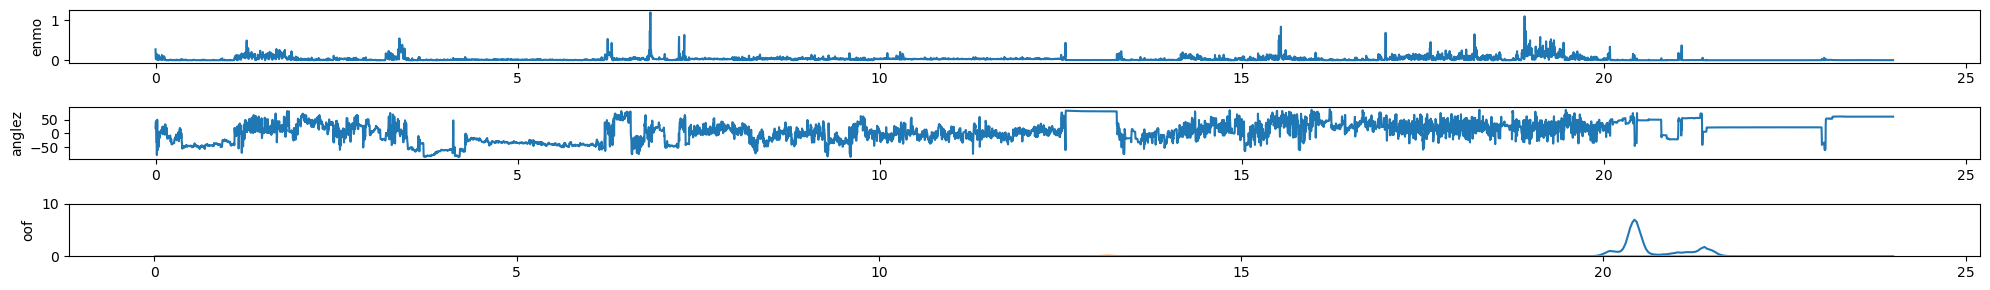

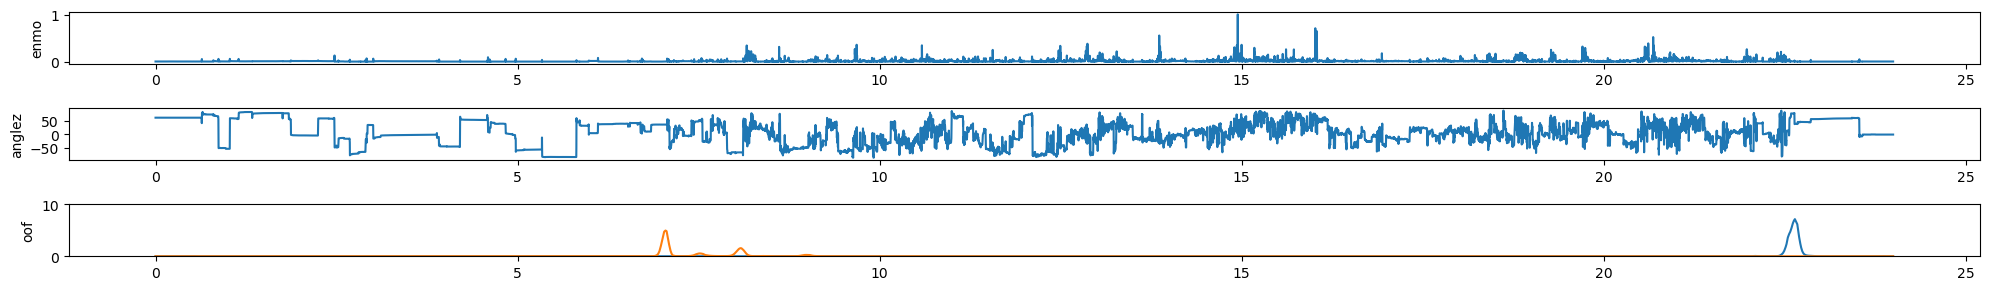

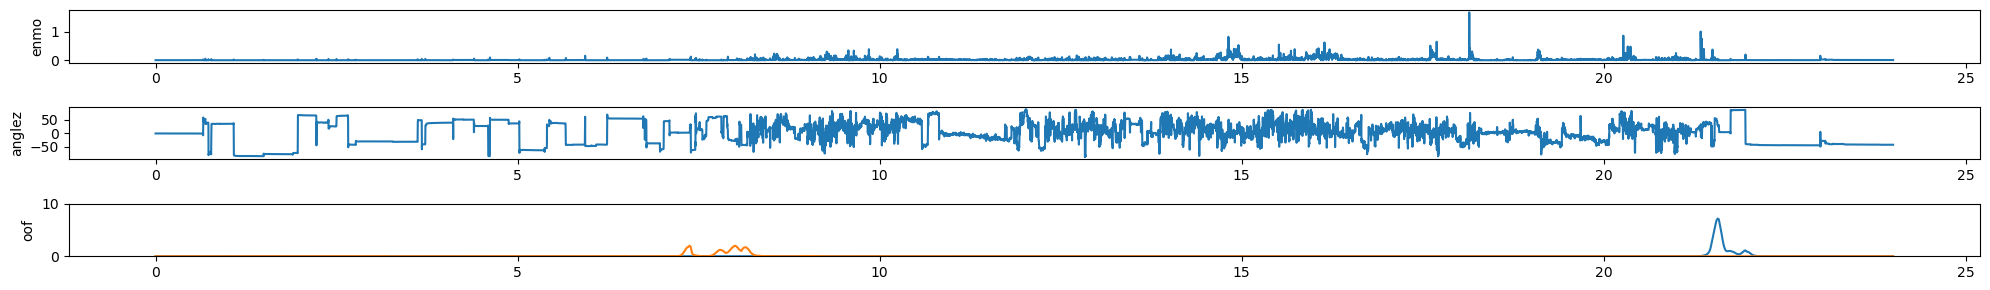

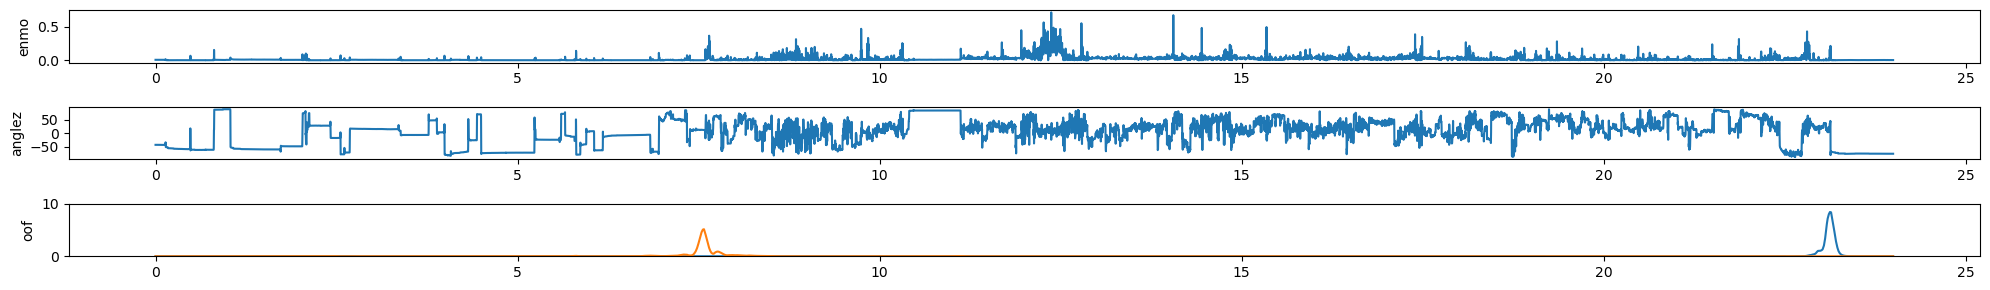

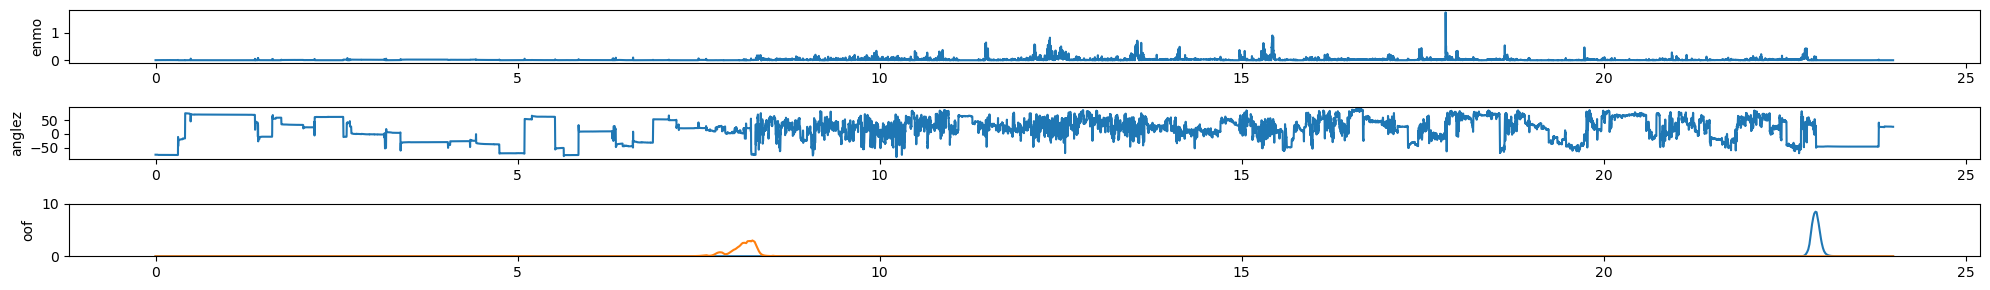

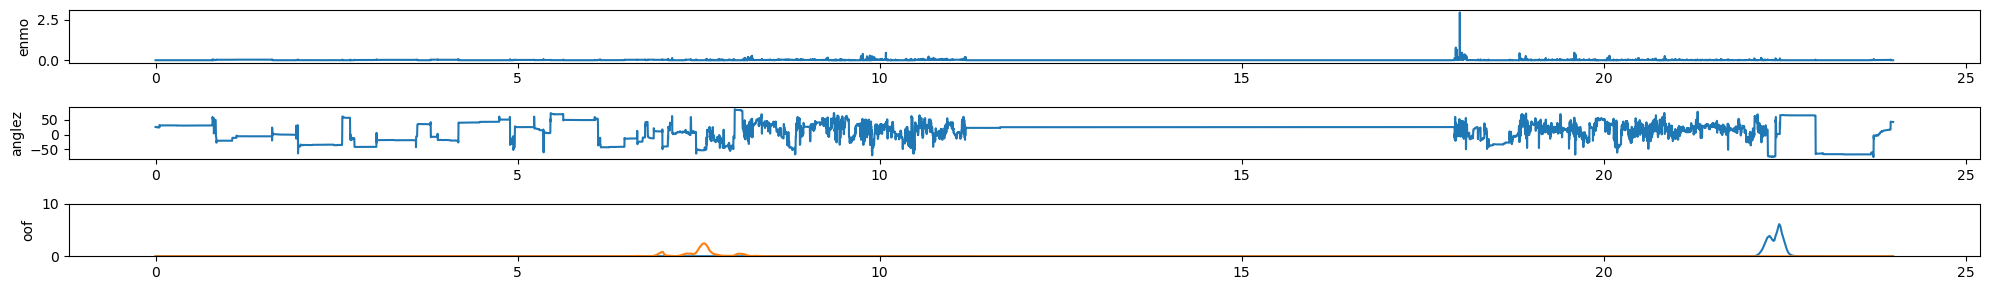

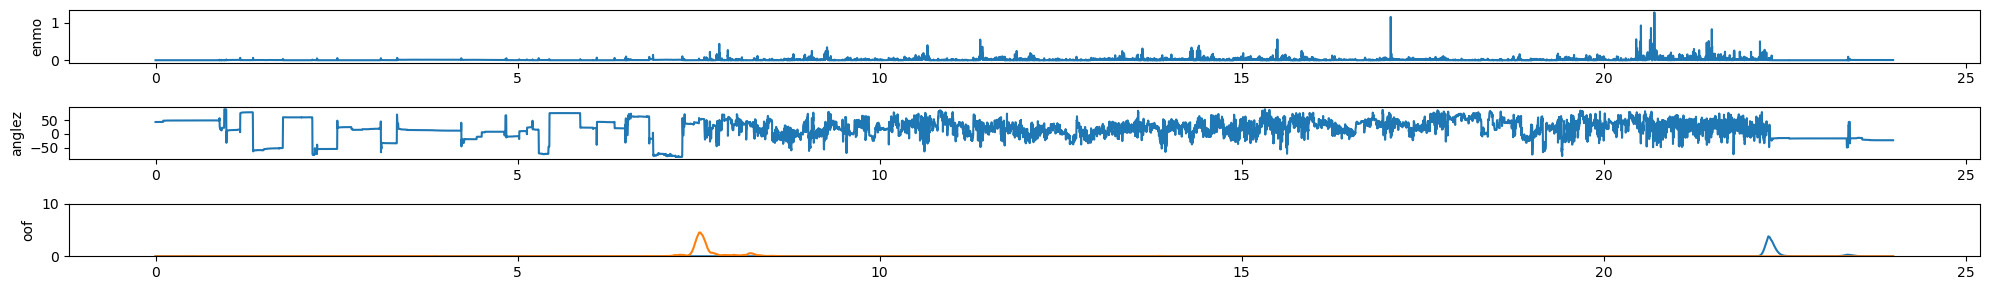

In [24]:
sample_file = "../working/features/sleep_detection/id=001f3379.parquet"

df = pl.read_parquet(sample_file)
df = df.with_columns(pl.col("step").cast(pl.UInt32)).drop("time_of_day")
sid = df["series_id"][0]

sensor_df = pl.read_parquet(
    f"../input/child-mind-institute-problematic-internet-use/series_{TRAIN_OR_TEST}.parquet/{sid}/part-0.parquet"
).with_columns((pl.col("time_of_day") == 0).cum_sum().alias("day"))

sensor_df = sensor_df.join(df, on="step", how="left").with_columns(
    pl.col("onset_oof").interpolate(),
    pl.col("wakeup_oof").interpolate(),
)

for (day, ), day_df in sensor_df.group_by("day", maintain_order=True):
    fig, axs = plt.subplots(3, 1, figsize=(20, 3))
    times = np.linspace(0, 24, len(day_df))
    axs[0].plot(times, day_df["enmo"])
    axs[0].set_ylabel("enmo")
    axs[1].plot(times, day_df["anglez"])
    axs[1].set_ylabel("anglez")
    axs[2].plot(times, day_df["onset_oof"])
    axs[2].plot(times, day_df["wakeup_oof"])
    axs[2].set_ylabel("oof")
    axs[2].set_ylim(0, 10)
    plt.tight_layout()
    plt.show()
    if day > 5:
        break

In [25]:
time_of_day_max = 86400000000000
all_files = sorted(glob("../working/features/sleep_detection/*.parquet"))
len(all_files)

952

In [26]:
features = []
debug_count = 0
for file in tqdm(all_files):
    df = pl.read_parquet(file)
    df = df.with_columns(pl.col("step").cast(pl.UInt32)).drop("time_of_day")
    sid = df["series_id"][0]

    sensor_df = pl.read_parquet(
        f"../input/child-mind-institute-problematic-internet-use/series_{TRAIN_OR_TEST}.parquet/{sid}/part-0.parquet"
    ).with_columns((pl.col("time_of_day") == 0).cum_sum().alias("day"))

    feature = {
        "id": sid,
        "length": df.shape[0],
        "day": sensor_df["relative_date_PCIAT"].max() - sensor_df["relative_date_PCIAT"].min(),
    }

    # skip if time step is not 5sec
    diffs = sensor_df["time_of_day"].diff().drop_nulls().unique()
    if set(diffs) != set([-86395000000000, 5000000000]):
        features.append(feature)
        continue

    sensor_df = (
        sensor_df.join(df, on="step", how="left")
        .sort("step")
        .with_columns(
            pl.col("onset_oof").interpolate(),
            pl.col("wakeup_oof").interpolate(),
        )
    )

    # onset = 15:00~3:00, wakeup = 3:00~15:00
    onset_start = time_of_day_max / 24 * 15  # 15:00
    onset_end = time_of_day_max / 24 * 3  # 3:00
    sensor_df = sensor_df.with_columns(
        ((pl.col("time_of_day") > onset_start) | (pl.col("time_of_day") < onset_end)).alias("onset_duration"),
    ).with_columns(
        pl.col("onset_duration").cast(pl.Int32).diff().fill_null(0).abs().cum_sum().alias("onset_wakeup_duration")
    )

    # get sleep period
    sleep_info = []
    for _, df in sensor_df.group_by("onset_wakeup_duration", maintain_order=True):
        is_onset = df["onset_duration"][0]
        if is_onset:
            max_idx = df["onset_oof"].arg_max()
            if max_idx is None:
                continue
            max_score = df["onset_oof"][max_idx]
            step = df["step"][max_idx]

            # date
            start_time = df["time_of_day"][0] / time_of_day_max * 24
            if start_time >= 15:
                day = df["day"][0]
                week_day = df["weekday"][0]
            else:
                day = df["day"][0] - 1
                week_day = df["weekday"][0] - 1
                if week_day == 0:
                    week_day = 7
        else:
            max_idx = df["wakeup_oof"].arg_max()
            if max_idx is None:
                continue
            max_score = df["wakeup_oof"][max_idx]
            step = df["step"][max_idx]

            # date
            start_time = df["time_of_day"][0] / time_of_day_max * 24
            day = df["day"][0] - 1
            week_day = df["weekday"][0] - 1

        info = {
            "day": day,
            "weekday": week_day,
            "type": "onset" if is_onset else "wakeup",
            "step": step,
            "max_score": max_score,
            "time": df["time_of_day"][max_idx] / time_of_day_max * 24,
        }
        sleep_info.append(info)
    sleep_df = pl.DataFrame(sleep_info)

    # merge
    sleep_df = (
        sleep_df.filter(pl.col("type") == "onset")
        .drop("type")
        .rename(
            {
                "max_score": "onset_score",
                "step": "onset_step",
                "time": "onset_time",
            }
        )
        .join(
            sleep_df.filter(pl.col("type") == "wakeup")
            .drop(["type", "weekday"])
            .rename(
                {
                    "max_score": "wakeup_score",
                    "step": "wakeup_step",
                    "time": "wakeup_time",
                }
            ),
            on="day",
        )
    ).select(
        ["day", "weekday", "onset_time", "wakeup_time", "onset_step", "wakeup_step", "onset_score", "wakeup_score"]
    )

    # feature engineering
    sleep_lengths = []  # wakeup - onset
    sleep_enmo_mean = []  
    sleep_enmo_std = []  
    sleep_light_mean = []
    sleep_light_std = [] 
    for i in range(len(sleep_df)):
        # sleep period
        start = sleep_df["onset_step"][i]
        end = sleep_df["wakeup_step"][i]
        if sleep_df["onset_score"][i] < 1 or sleep_df["wakeup_score"][i] < 1:
            sleep_lengths.append(np.nan)
            sleep_enmo_mean.append(np.nan)
            sleep_enmo_std.append(np.nan)
            sleep_light_mean.append(np.nan)
            sleep_light_std.append(np.nan)
            continue

        # sleep length
        length = end - start
        sleep_lengths.append(length * 5 / 60 / 60)  # hour

        # enmo
        enmo_mean = sensor_df["enmo"][start:end].mean()
        enmo_std = sensor_df["enmo"][start:end].std()
        sleep_enmo_mean.append(enmo_mean)
        sleep_enmo_std.append(enmo_std)

        # light
        light_mean = sensor_df["light"][start:end].mean()
        light_std = sensor_df["light"][start:end].std()
        sleep_light_mean.append(light_mean)
        sleep_light_std.append(light_std)
        
    sleep_df = sleep_df.with_columns(
        pl.DataFrame(
            {
                "sleep_length": sleep_lengths,
                "sleep_enmo_mean": sleep_enmo_mean,
                "sleep_enmo_std": sleep_enmo_std,
                "sleep_light_mean": sleep_light_mean,
                "sleep_light_std": sleep_light_std,
            }
        )
    )
    
    # leave only high confidence periods
    sleep_df = sleep_df.filter((pl.col("wakeup_score") > 1) & (pl.col("onset_score") > 1))
    if debug_count < 3:
        display(sleep_df.head())
    debug_count += 1
        

    # agg
    feature.update(
        {
            "sleep_measurement_count": sleep_df.shape[0],
            "sleep_length_mean": sleep_df["sleep_length"].mean(),
            "sleep_length_std": sleep_df["sleep_length"].std(),
            "sleep_start_mean": sleep_df["onset_time"].mean(),
            "sleep_start_std": sleep_df["onset_time"].std(),
            "sleep_end_mean": sleep_df["wakeup_time"].mean(),
            "sleep_end_std": sleep_df["wakeup_time"].std(),
            "sleep_enmo_mean_mean": sleep_df["sleep_enmo_mean"].mean(),
            "sleep_enmo_mean_std": sleep_df["sleep_enmo_mean"].std(),
            "sleep_enmo_std_mean": sleep_df["sleep_enmo_std"].mean(),
            "sleep_enmo_std_std": sleep_df["sleep_enmo_std"].std(),
            "sleep_light_mean_mean": sleep_df["sleep_light_mean"].mean(),
            "sleep_light_mean_std": sleep_df["sleep_light_mean"].std(),
            "sleep_light_std_mean": sleep_df["sleep_light_std"].mean(),
            "sleep_light_std_std": sleep_df["sleep_light_std"].std(),
        }
    )
    features.append(feature)
    
feature_df = pl.DataFrame(features).with_columns(pl.col("id").str.slice(3, 8))
feature_df.head()

  0%|          | 0/952 [00:00<?, ?it/s]

day,weekday,onset_time,wakeup_time,onset_step,wakeup_step,onset_score,wakeup_score,sleep_length,sleep_enmo_mean,sleep_enmo_std,sleep_light_mean,sleep_light_std
i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64
0,2,22.091667,7.041667,7854,14298,6.946261,4.964302,8.95,0.003588,0.008487,2.06153,0.52031
1,3,22.641667,7.375,25530,31818,7.148475,2.016238,8.733333,0.002221,0.005326,2.890625,1.157738
2,4,21.575,7.575,42042,49242,7.167502,5.137747,10.0,0.003952,0.007145,6.449369,2.735749
3,5,23.125,8.241667,60438,67002,8.424463,3.014895,9.116667,0.006067,0.008371,9.249772,14.24697
4,6,22.925,7.575,77574,83802,8.476061,2.475417,8.65,0.009829,0.012694,0.81042,1.658199


  0%|          | 2/952 [00:00<01:06, 14.23it/s]

day,weekday,onset_time,wakeup_time,onset_step,wakeup_step,onset_score,wakeup_score,sleep_length,sleep_enmo_mean,sleep_enmo_std,sleep_light_mean,sleep_light_std
i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64
0,1,23.541667,6.241667,5502,10326,8.612468,5.84382,6.7,0.004685,0.009849,1.539572,0.252807
1,2,23.108333,7.158333,22470,28266,8.572758,6.995841,8.05,0.004033,0.007475,0.740108,0.131363
2,3,23.658333,7.158333,40146,45546,8.086097,6.743721,7.5,0.002491,0.007888,16.573546,2.140778
3,4,23.475,6.775,57294,62550,7.9827,3.590256,7.3,0.004812,0.0089,10.480734,0.901367
4,5,0.325,7.191667,75186,80130,6.458125,8.493128,6.866667,0.003783,0.009157,0.773354,0.143684


day,weekday,onset_time,wakeup_time,onset_step,wakeup_step,onset_score,wakeup_score,sleep_length,sleep_enmo_mean,sleep_enmo_std,sleep_light_mean,sleep_light_std
i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64
0,2,21.608333,5.791667,3822,9714,7.809194,8.071363,8.183333,0.004292,0.011189,2.44575,1.605728
1,3,22.325,6.325,21618,27378,7.4608,7.190278,8.0,0.007874,0.015459,4.015484,1.127654
2,4,22.025,6.025,38682,44442,8.760675,8.779506,8.0,0.003032,0.00892,14.439213,6.766565
3,5,0.558333,7.058333,57786,62466,7.075278,6.984324,6.5,0.004309,0.008971,0.750395,0.133539
4,6,22.375,6.891667,73494,79626,8.155587,7.328327,8.516667,0.007884,0.014056,1.867484,1.009006


100%|██████████| 952/952 [01:30<00:00, 10.48it/s]


id,length,day,sleep_measurement_count,sleep_length_mean,sleep_length_std,sleep_start_mean,sleep_start_std,sleep_end_mean,sleep_end_std,sleep_enmo_mean_mean,sleep_enmo_mean_std,sleep_enmo_std_mean,sleep_enmo_std_std,sleep_light_mean_mean,sleep_light_mean_std,sleep_light_std_mean,sleep_light_std_std
str,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00115b9f""",3610,44.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""001f3379""",33033,23.0,7,8.907143,0.652762,22.436905,0.523142,7.344048,0.658311,0.005069,0.002446,0.008205,0.00229,4.986645,4.308014,3.462045,4.881914
"""00f332d1""",34532,24.0,21,8.042857,1.075066,20.853571,6.86969,7.182143,0.390924,0.004878,0.002818,0.00868,0.002426,18.147637,30.043263,5.105706,10.096801
"""01085eb3""",30913,22.0,20,8.280833,0.850392,20.805833,4.809458,6.286667,0.445973,0.005313,0.001844,0.012091,0.002144,9.230379,8.509131,3.166961,2.978369
"""012cadd8""",8087,6.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [27]:
feature_df.write_csv("../working/features/sleep_features.csv")